# Simply CNN
Training (and test) CNN at MNIST data end validation at own unseen examples

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


import matplotlib.pyplot as plt
import seaborn as sns

import time

import os
from PIL import Image

import functions.preprocess_my_numbers as my_pr
import importlib
import functions.training as my_tr


importlib.reload(my_tr)
importlib.reload(my_pr)

<module 'functions.preprocess_my_numbers' from 'C:\\Users\\piecz\\PycharmProjects\\basic_of_ml_image_classification\\functions\\preprocess_my_numbers.py'>

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 28x28 -> 28x28
        self.pool = nn.MaxPool2d(2, 2)                           # -> 14x14
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)



In [13]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):
    model.train()
    total_loss = 0
    
    i=0
    for data, target in train_loader:
        i+=1
        if i%100 == 0:
            print(f"{i//100} of {60000 / (100*100)}")
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, loss: {total_loss:.4f}")

1 of 6.0
2 of 6.0
3 of 6.0
4 of 6.0
5 of 6.0
6 of 6.0
7 of 6.0
8 of 6.0
9 of 6.0
Epoch 1, loss: 108.4866
1 of 6.0
2 of 6.0
3 of 6.0
4 of 6.0
5 of 6.0
6 of 6.0
7 of 6.0
8 of 6.0
9 of 6.0
Epoch 2, loss: 32.5956
1 of 6.0
2 of 6.0
3 of 6.0
4 of 6.0
5 of 6.0
6 of 6.0
7 of 6.0
8 of 6.0
9 of 6.0
Epoch 3, loss: 19.8467
1 of 6.0
2 of 6.0
3 of 6.0
4 of 6.0
5 of 6.0
6 of 6.0
7 of 6.0
8 of 6.0
9 of 6.0
Epoch 4, loss: 14.8836
1 of 6.0
2 of 6.0
3 of 6.0
4 of 6.0
5 of 6.0
6 of 6.0
7 of 6.0
8 of 6.0
9 of 6.0
Epoch 5, loss: 9.7179


In [20]:
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        output = model(data)
        preds = output.argmax(dim=1).cpu().numpy()

        all_preds.append(preds)
        all_targets.append(target.numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

Accuracy: 98.86%


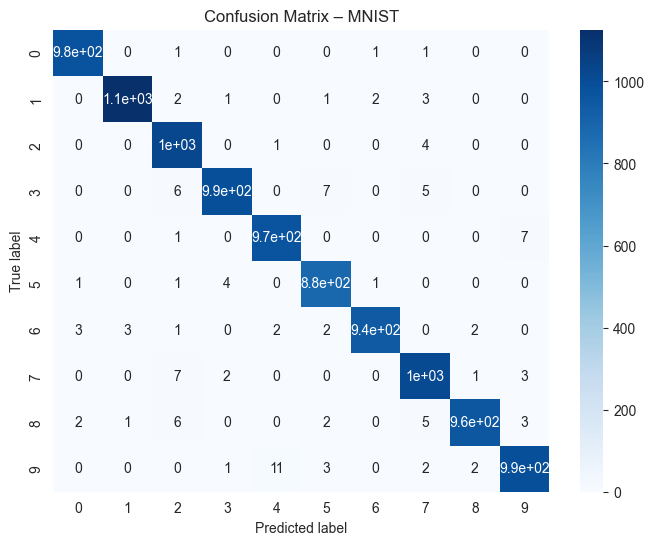

In [24]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_targets, all_preds)
accuracy = np.mean(all_preds == all_targets)
print(f"Accuracy: {accuracy * 100:.2f}%")


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    cmap="Blues",
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – MNIST")
plt.show()

In [25]:
torch.save(model, "data/models/simply-cnn_17-12-2025.pth")

### Test at my own data

In [50]:
IMAGE_DIR = "data//images_labelled"

image_paths = [
    os.path.join(IMAGE_DIR, fname)
    for fname in os.listdir(IMAGE_DIR)
    if fname.lower().endswith(".png")
]

print(f"{len(image_paths)} images was founded")

86 images was founded


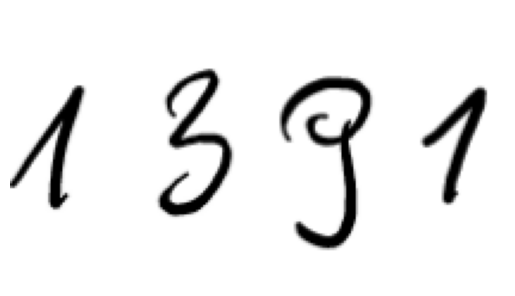

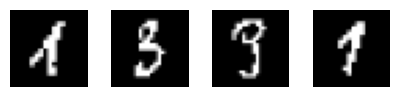

True: 1391
Prediction: 1337
----

ERROR!!!


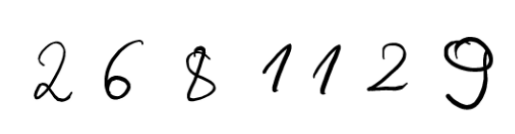

number of detected digits: 8 (7)
----



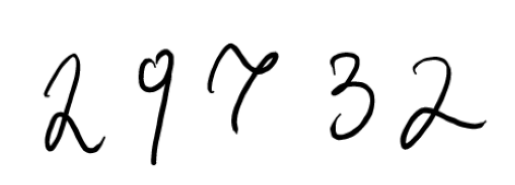

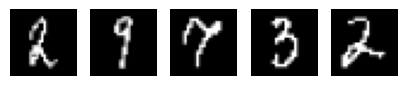

True: 29732
Prediction: 27832
----



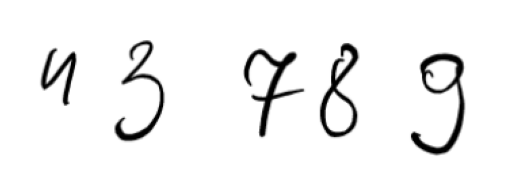

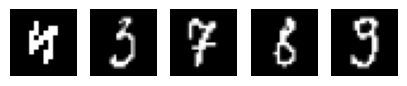

True: 43789
Prediction: 45785
----

ERROR!!!


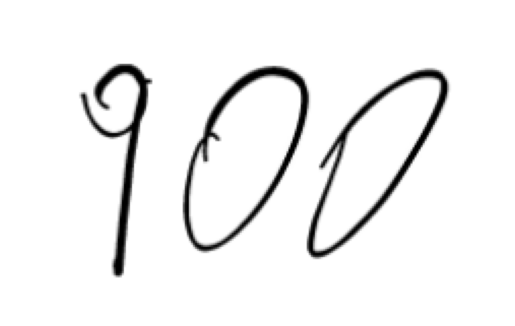

number of detected digits: 2 (3)
----

ERROR!!!


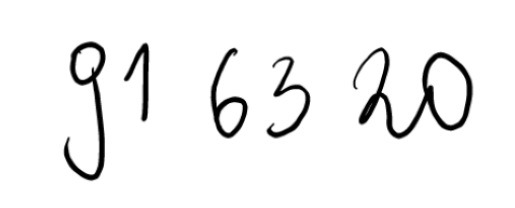

number of detected digits: 5 (6)
----



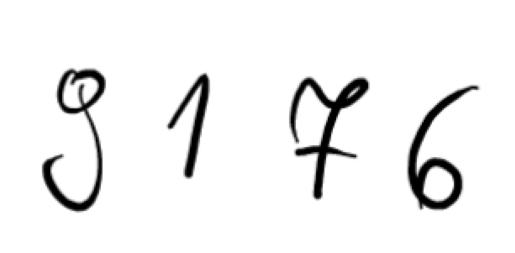

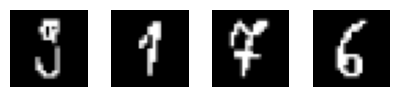

True: 9176
Prediction: 5156
----

Number of wrong splits: 3 of 86


In [51]:
digit_size,margin,blur_ksize, new_height = (26, 2, 0, 28)

whole_num_res = []
digit_res = []

wrong_split = 0
for p in image_paths:
    label = p.split("\\")[-1].split("-")[0] 
    label_list = list(label)
    
    img = Image.open(p).convert('L')
    
    img_resized = my_pr.resize(img,new_height=new_height)
    digits = my_pr.split_to_digits(img_resized)    
    digits = my_pr.prepare_digits_for_mnist(digits,blur_ksize=blur_ksize,n=digit_size,margin=margin)
       
    
    if len(digits) != len(label_list):
        print("ERROR!!!")
        plt.imshow(np.array(img), cmap='gray')
        plt.axis('off')
        plt.show()
        print(f"number of detected digits: {len(digits)} ({len(label_list)})")
        print("----\n")
        
        wrong_split +=1
        continue
    
    result = []
    number = []

    for i, d in zip(label_list, digits):
        if isinstance(d, np.ndarray) and d.ndim == 3:
            d = d.squeeze(-1)
    
        d_tensor = torch.tensor(d, dtype=torch.float32)
    
        d_tensor = d_tensor.unsqueeze(0).unsqueeze(0)
    
        d_tensor = (d_tensor - 0.1307) / 0.3081
    
        d_tensor = d_tensor.to(next(model.parameters()).device)
    
        output = model(d_tensor)
        pred = torch.argmax(output, dim=1).item()
    
        result.append((int(i), int(pred)))
        number.append(pred)
        
    number = int(''.join(str(n) for n in number))
    digit_res = digit_res + result
    global_res = len([(x,y) for x ,y in result if x==y])/len(result)
    whole_num_res.append((int(label), number, global_res))
    
    
    if len([(x,y) for x ,y in result if x!=y])>1:
        plt.imshow(np.array(img), cmap='gray')
        plt.axis('off')
        plt.show()
        
        plt.figure(figsize=(5, 1))
        for i, d in enumerate(digits):
            plt.subplot(1, len(digits), i + 1)
            plt.imshow(d, cmap="gray")
            plt.axis("off")
        plt.show()
    
        print("True:",label)
        print("Prediction:",number)
        print("----\n")
    
print(f"Number of wrong splits: {wrong_split} of {len(image_paths)}")

Accuracy: 0.9269


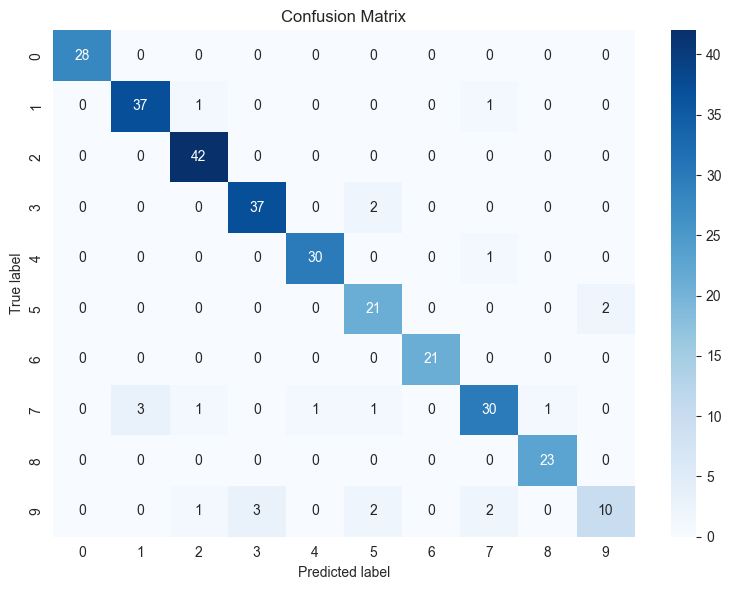

In [52]:
correct = sum(1 for t, p in digit_res if t == p)
total = len(digit_res)

accuracy = correct / total if total > 0 else 0.0

print(f"Accuracy: {accuracy:.4f}")

import seaborn as sns
import matplotlib.pyplot as plt

num_classes = 10

confusion = np.zeros((num_classes, num_classes), dtype=int)

for true, pred in digit_res:
    confusion[true, pred] += 1

plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(10),
    yticklabels=range(10)
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Fraction of good predictions for whole numbers: 78.31%


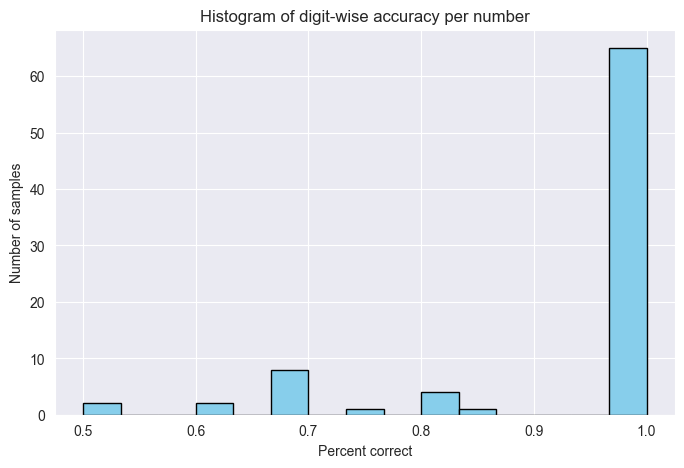

In [53]:
percent_values = [x[2] for x in whole_num_res]  
num_correct = sum(1 for v in percent_values if v == 1.0)
percent_correct = num_correct / len(percent_values) * 100

print(f"Fraction of good predictions for whole numbers: {percent_correct:.2f}%")

plt.figure(figsize=(8, 5))
plt.hist(percent_values, bins=15, color='skyblue', edgecolor='black')
plt.xlabel("Percent correct")
plt.ylabel("Number of samples")
plt.title("Histogram of digit-wise accuracy per number")
plt.show()